In [1]:
# Ecommerce Data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from scipy.spatial.distance import cdist
import faiss
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

In [3]:
customers = pd.read_csv("Customers Data.csv")
products = pd.read_csv("Products.csv")
transactions = pd.read_csv("Transactions.csv")

In [23]:
print("Customers: \t \n")
customers.info()
print("Customers Duplicates:", customers.duplicated().sum())
print("\n")
print(f"Customers Missing values? \n {customers.isnull().sum()}")
print("\n")
print("Products: \t \n")
products.info()
print("Products Duplicates:", products.duplicated().sum())
print("\n")
print(f"products missing values? \n {products.isnull().sum()}")
print("\n")
print("transactions : \t \n")
transactions.info()
print("Transactions Duplicates:", transactions.duplicated().sum())
print("\n")
print(f"Transactions missing values? \n {transactions.isnull().sum()}")

Customers: 	 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
Customers Duplicates: 0


Customers Missing values? 
 CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64


Products: 	 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.2+ KB
Products Duplicates: 0


pr

In [24]:
customers.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [25]:
products.head()

,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.30
1,P002,ActiveWear Smartwatch,Electronics,346.30
2,P003,ComfortLiving Biography,Books,44.12
3,P004,BookWorld Rug,Home Decor,95.69
4,P005,TechPro T-Shirt,Clothing,429.31


In [26]:
transactions.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [27]:
sns.set_theme()

In [29]:
for name, df in [('Customers', customers), 
                    ('Products', products), 
                    ('Transactions', transactions)]:
        print(f"\nShape: {df.shape}")
        print("\nUnique Values per Column:")
        print(df.nunique())


Shape: (200, 4)

Unique Values per Column:
CustomerID      200
CustomerName    200
Region            4
SignupDate      179
dtype: int64

Shape: (100, 4)

Unique Values per Column:
ProductID      100
ProductName     66
Category         4
Price          100
dtype: int64

Shape: (1000, 7)

Unique Values per Column:
TransactionID      1000
CustomerID          199
ProductID           100
TransactionDate    1000
Quantity              4
TotalValue          369
Price               100
dtype: int64


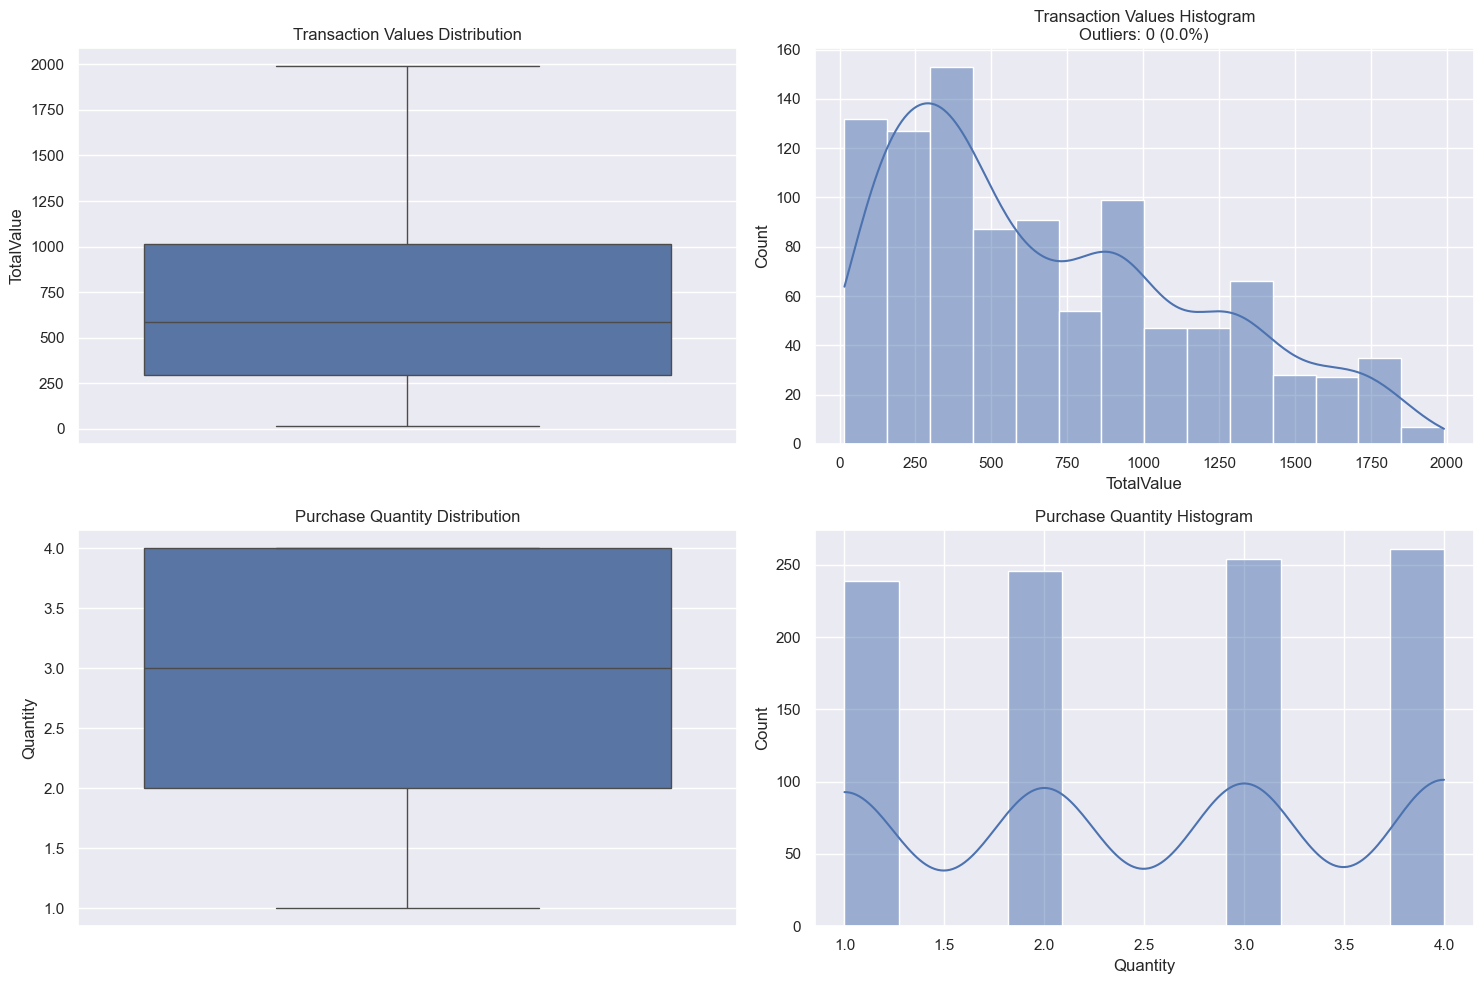

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
#understand about transactions by boxplot
sns.boxplot(y=transactions['TotalValue'], ax=axes[0,0])
axes[0,0].set_title('Transaction Values Distribution')
# Detect outliers
Q1 = transactions['TotalValue'].quantile(0.25)
Q3 = transactions['TotalValue'].quantile(0.75)
IQR = Q3 - Q1
outliers = transactions[(transactions['TotalValue'] < (Q1 - 1.5 * IQR)) | 
                              (transactions['TotalValue'] > (Q3 + 1.5 * IQR))]
#histogram
sns.histplot(transactions['TotalValue'], kde=True, ax=axes[0,1])
axes[0,1].set_title(f'Transaction Values Histogram\nOutliers: {len(outliers)} ({len(outliers)/len(transactions)*100:.1f}%)')
#quantity 
sns.boxplot(y=transactions['Quantity'], ax=axes[1,0])
axes[1,0].set_title('Purchase Quantity Distribution')
sns.histplot(transactions['Quantity'], kde=True, ax=axes[1,1])
axes[1,1].set_title('Purchase Quantity Histogram')
plt.tight_layout()
plt.show()

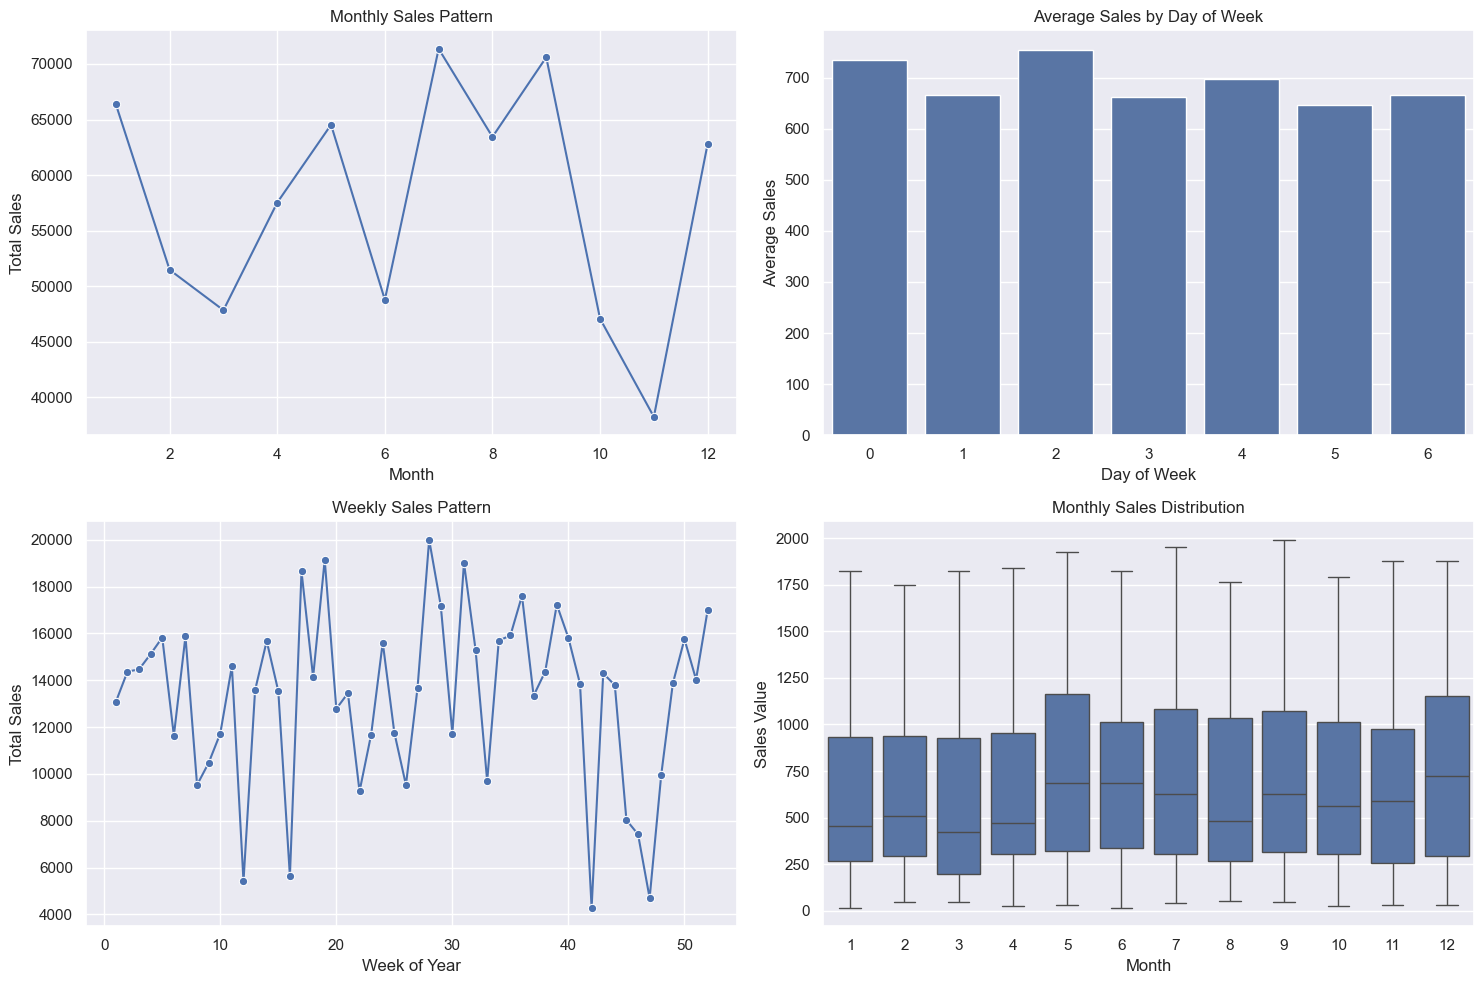

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

#get pandas datetime object for easy manipulation
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])
transactions['Year'] = transactions['TransactionDate'].dt.year
transactions['Month'] = transactions['TransactionDate'].dt.month
transactions['DayOfWeek'] = transactions['TransactionDate'].dt.dayofweek
transactions['WeekOfYear'] = transactions['TransactionDate'].dt.isocalendar().week

# monthly Sales Pattern
monthly_sales = transactions.groupby('Month')['TotalValue'].sum()
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values, ax=axes[0,0], marker='o')
axes[0,0].set_title('Monthly Sales Pattern')
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('Total Sales')

# daily Sales Pattern
daily_sales = transactions.groupby('DayOfWeek')['TotalValue'].mean()
sns.barplot(x=daily_sales.index, y=daily_sales.values, ax=axes[0,1])
axes[0,1].set_title('Average Sales by Day of Week')
axes[0,1].set_xlabel('Day of Week')
axes[0,1].set_ylabel('Average Sales')

# weekly Sales Pattern
weekly_sales = transactions.groupby('WeekOfYear')['TotalValue'].sum()
sns.lineplot(x=weekly_sales.index, y=weekly_sales.values, ax=axes[1,0], marker='o')
axes[1,0].set_title('Weekly Sales Pattern')
axes[1,0].set_xlabel('Week of Year')
axes[1,0].set_ylabel('Total Sales')

# monthly Sales Distribution (Box Plot)
sns.boxplot(x='Month', y='TotalValue', data=transactions, ax=axes[1,1])
axes[1,1].set_title('Monthly Sales Distribution')
axes[1,1].set_xlabel('Month')
axes[1,1].set_ylabel('Sales Value')

plt.tight_layout()
plt.show()

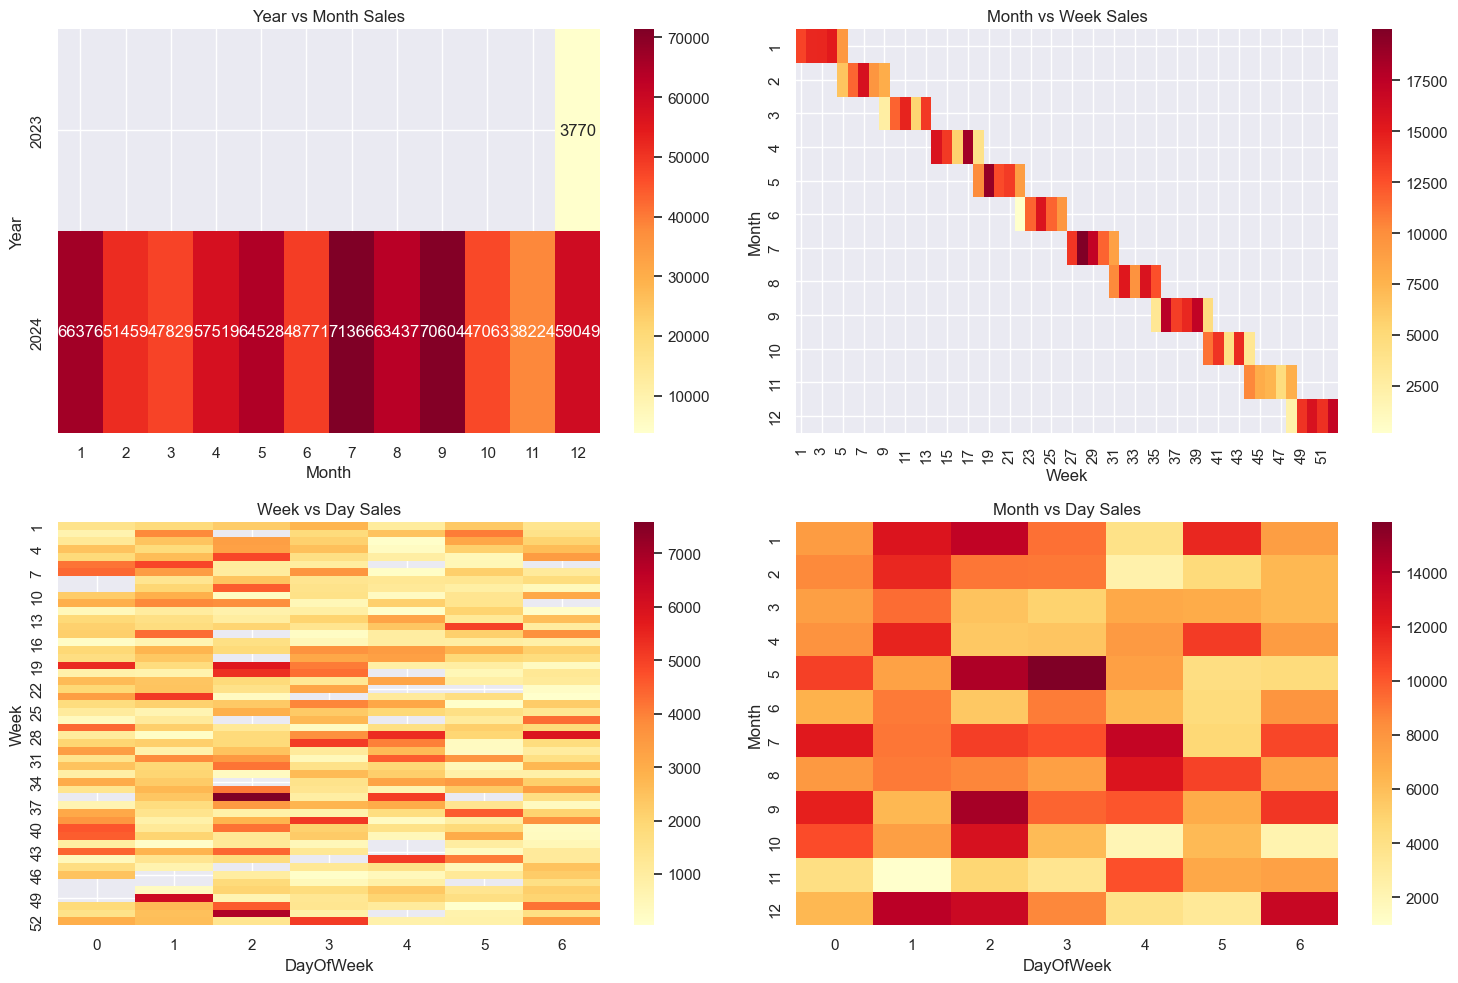

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

#datetime components (remaining)
transactions['Week'] = transactions['TransactionDate'].dt.isocalendar().week

#year vs month heatmap
yearly_monthly = pd.pivot_table(transactions, 
                               values='TotalValue',
                               index='Year', 
                               columns='Month',
                               aggfunc='sum')
sns.heatmap(yearly_monthly, ax=axes[0,0], cmap='YlOrRd', annot=True, fmt='.0f')
axes[0,0].set_title('Year vs Month Sales')

#month vs week
monthly_weekly = pd.pivot_table(transactions, 
                               values='TotalValue',
                               index='Month', 
                               columns='Week',
                               aggfunc='sum')
sns.heatmap(monthly_weekly, ax=axes[0,1], cmap='YlOrRd')
axes[0,1].set_title('Month vs Week Sales')

#week vs daily
weekly_daily = pd.pivot_table(transactions, 
                             values='TotalValue',
                             index='Week', 
                             columns='DayOfWeek',
                             aggfunc='sum')
sns.heatmap(weekly_daily, ax=axes[1,0], cmap='YlOrRd')
axes[1,0].set_title('Week vs Day Sales')

#month vs day
monthly_daily = pd.pivot_table(transactions, 
                              values='TotalValue',
                              index='Month', 
                              columns='DayOfWeek',
                              aggfunc='sum')
sns.heatmap(monthly_daily, ax=axes[1,1], cmap='YlOrRd')
axes[1,1].set_title('Month vs Day Sales')


plt.tight_layout()
plt.show()

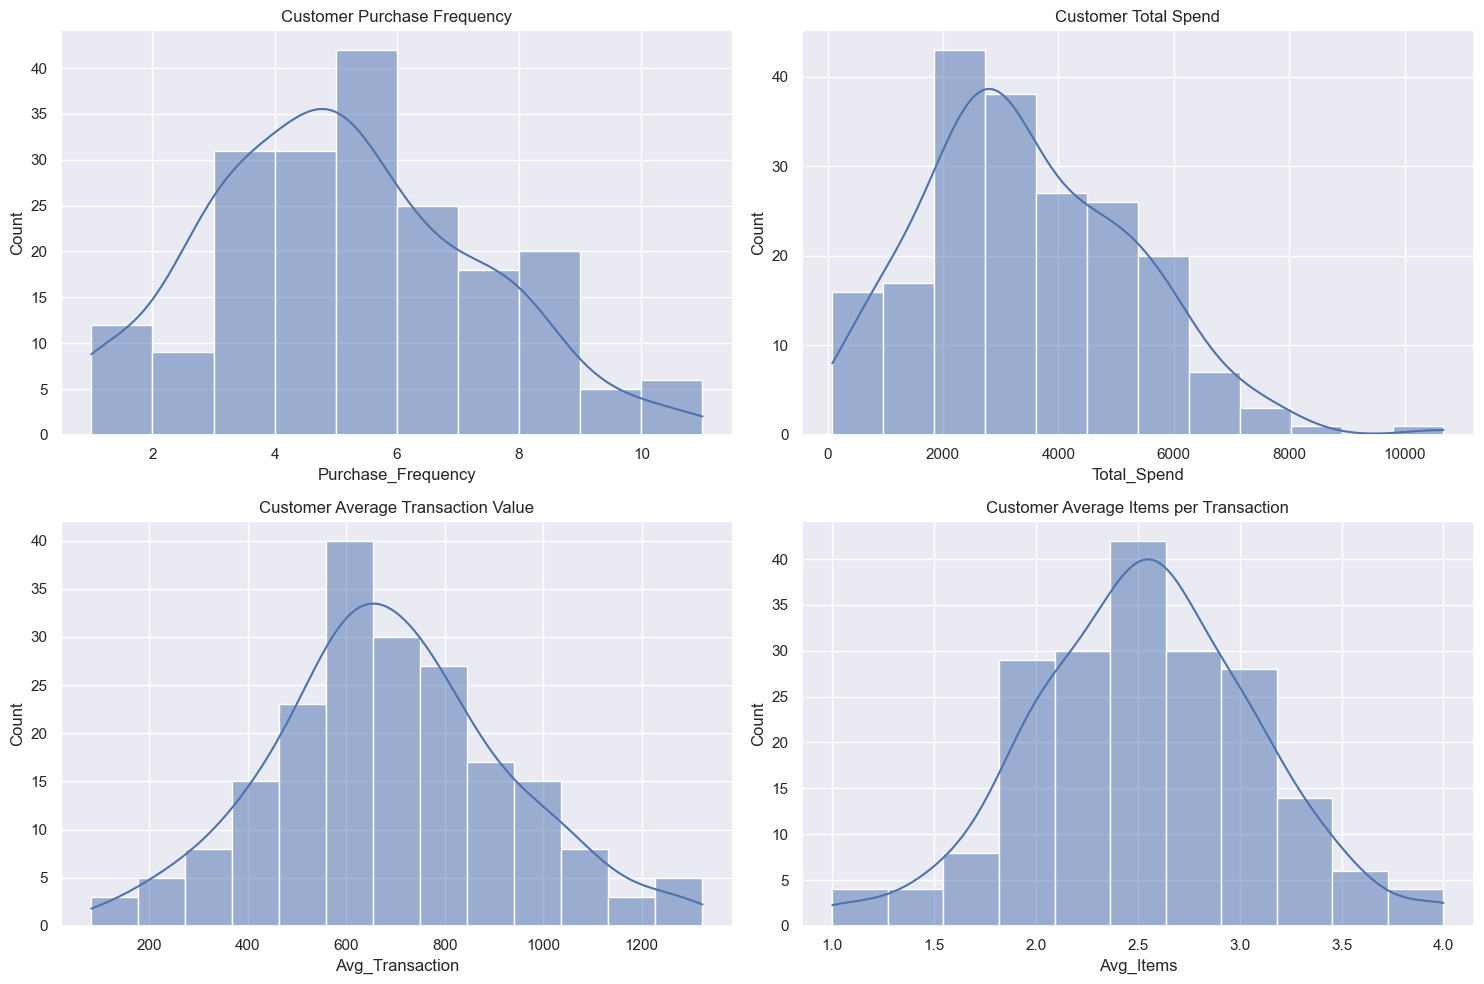

In [41]:
# customer analysis
customer_metrics = transactions.groupby('CustomerID').agg({
        'TransactionID': 'count',
        'TotalValue': ['sum', 'mean'],
        'Quantity': ['sum', 'mean']
    })
customer_metrics.columns = ['Purchase_Frequency', 'Total_Spend', 'Avg_Transaction', 'Total_Items', 'Avg_Items']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
#histogram plot
sns.histplot(customer_metrics['Purchase_Frequency'], kde=True, ax=axes[0,0])
axes[0,0].set_title('Customer Purchase Frequency')
# total spent
sns.histplot(customer_metrics['Total_Spend'], kde=True, ax=axes[0,1])
axes[0,1].set_title('Customer Total Spend')
# average transaction
sns.histplot(customer_metrics['Avg_Transaction'], kde=True, ax=axes[1,0])
axes[1,0].set_title('Customer Average Transaction Value')
# average items 
sns.histplot(customer_metrics['Avg_Items'], kde=True, ax=axes[1,1])
axes[1,1].set_title('Customer Average Items per Transaction')
    
plt.tight_layout()
plt.show()
    
 


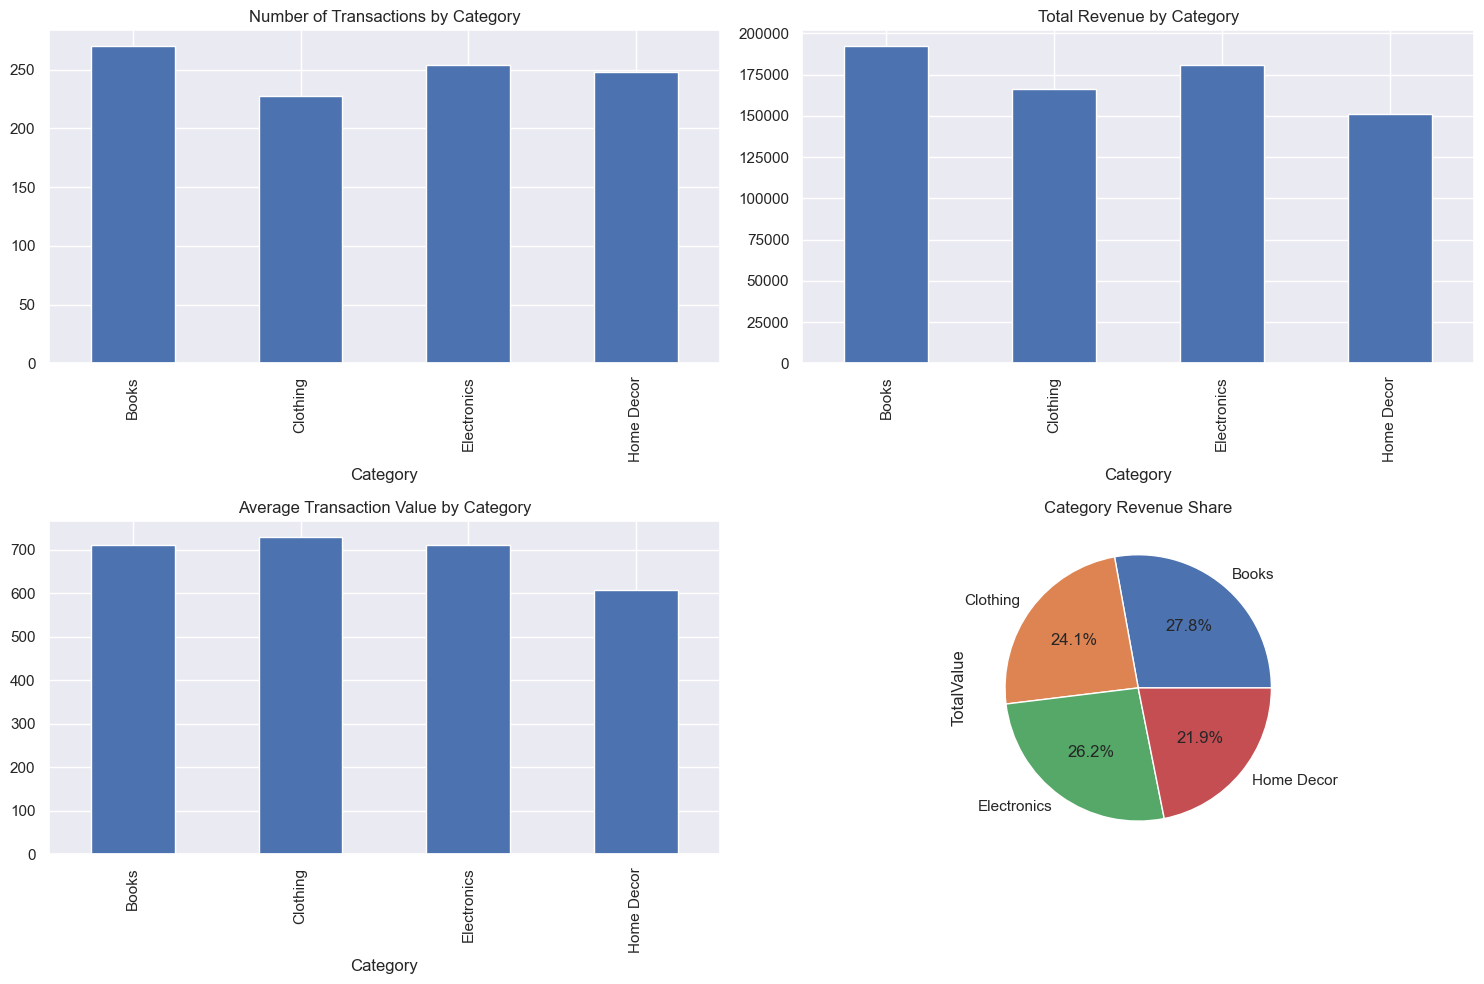

In [42]:
# we analyze performance by product categories now, so we gotta merge.
category_data = transactions.merge(products[['ProductID', 'Category']], on='ProductID')
category_metrics = category_data.groupby('Category').agg({
        'TransactionID': 'count',
        'TotalValue': ['sum', 'mean'],
        'Quantity': ['sum', 'mean']
    })
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# transaction count by category
category_data.groupby('Category')['TransactionID'].count().plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Number of Transactions by Category')
# total revenue by category
category_data.groupby('Category')['TotalValue'].sum().plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Total Revenue by Category')
# average transaction value by category
category_data.groupby('Category')['TotalValue'].mean().plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Average Transaction Value by Category')
# category pie chart
category_data.groupby('Category')['TotalValue'].sum().plot(kind='pie', ax=axes[1,1], autopct='%1.1f%%')
axes[1,1].set_title('Category Revenue Share')
plt.tight_layout()
plt.show()


In [43]:
customers['SignupDate']=pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [44]:
total_customers=len(customers)
print("Total customers:")
print(total_customers)
print("\n")
print("Customers by region:")
print(customers['Region'].value_counts())
print("\n")

Total customers:
200


Customers by region:
Region
South America    59
Europe           50
North America    46
Asia             45
Name: count, dtype: int64




In [45]:
#as we already created a datetime object so pandas can understand date parameters, we can now create a new SignupMonth
#so that we can understand which month has highest signups
customers['SignupMonth'] = customers['SignupDate'].dt.to_period('M')
monthly_signups = customers['SignupMonth'].value_counts().sort_index()
monthly_signups

SignupMonth
2022-01     1
2022-02     7
2022-03     8
2022-04     8
2022-05     8
2022-06     5
2022-07     4
2022-08     4
2022-09     6
2022-10     3
2022-11     3
2022-12     7
2023-01     5
2023-02     6
2023-03     8
2023-04     6
2023-05     3
2023-06     3
2023-07     3
2023-08     2
2023-09     4
2023-10     7
2023-11     5
2023-12     5
2024-01     9
2024-02     8
2024-03     4
2024-04    10
2024-05     6
2024-06     4
2024-07     6
2024-08     4
2024-09    11
2024-10     5
2024-11    11
2024-12     1
Freq: M, Name: count, dtype: int64

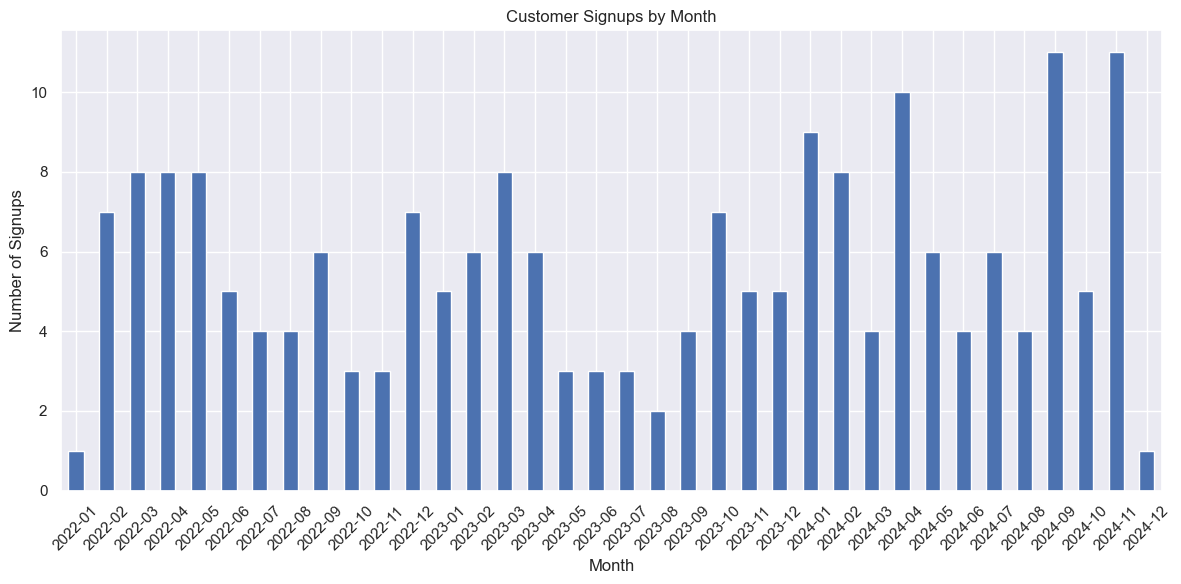

In [46]:
plt.figure(figsize=(12, 6))
monthly_signups.plot(kind='bar')
plt.title('Customer Signups by Month')
plt.xlabel('Month')
plt.ylabel('Number of Signups')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Total number of products:
100
Products by Category:


Category
Books          26
Electronics    26
Clothing       25
Home Decor     23
Name: count, dtype: int64

Price Statistics:
count    100.000000
mean     267.551700
std      143.219383
min       16.080000
25%      147.767500
50%      292.875000
75%      397.090000
max      497.760000
Name: Price, dtype: float64


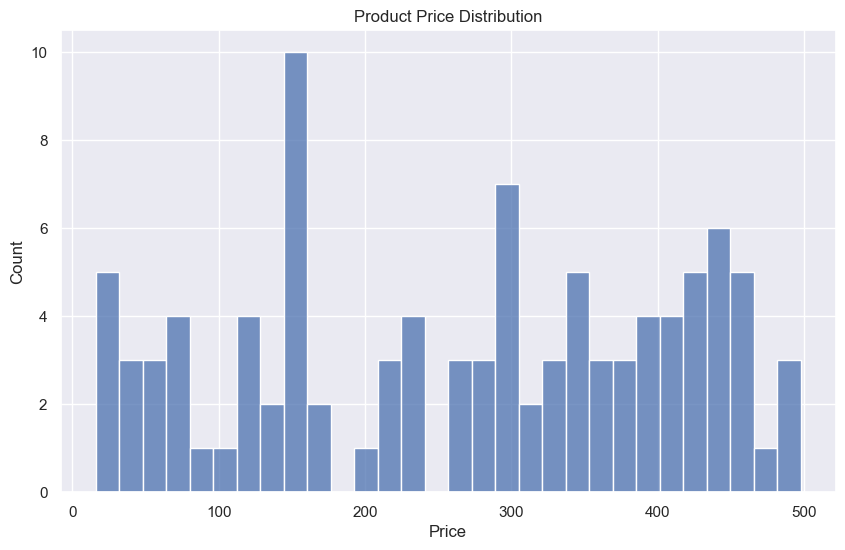

In [48]:
print("Total number of products:")
print(len(products))
print("Products by Category:")
print("\n")
print(products['Category'].value_counts())
print("\nPrice Statistics:")
print(products['Price'].describe())
plt.figure(figsize=(10, 6))
sns.histplot(data=products, x='Price', bins=30)
plt.title('Product Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

In [49]:
full_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')
full_data

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,Year,Month,DayOfWeek,Hour,WeekOfYear,Week,CustomerName,Region,SignupDate,SignupMonth,ProductName,Category,Price_y
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,2024,8,6,12,34,34,Andrea Jenkins,Europe,2022-12-03,2022-12,ComfortLiving Bluetooth Speaker,Electronics,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,2024,5,0,22,22,22,Brittany Harvey,Asia,2024-09-04,2024-09,ComfortLiving Bluetooth Speaker,Electronics,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,2024,4,3,7,17,17,Kathryn Stevens,Europe,2024-04-04,2024-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,2024,3,1,22,13,13,Travis Campbell,South America,2024-04-11,2024-04,ComfortLiving Bluetooth Speaker,Electronics,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,2024,3,3,15,12,12,Timothy Perez,Europe,2022-03-15,2022-03,ComfortLiving Bluetooth Speaker,Electronics,300.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,T00496,C0118,P037,2024-10-24 08:30:27,1,459.86,459.86,2024,10,3,8,43,43,Jacob Holt,South America,2022-01-22,2022-01,SoundWave Smartwatch,Electronics,459.86
996,T00759,C0059,P037,2024-06-04 02:15:24,3,1379.58,459.86,2024,6,1,2,23,23,Mrs. Kimberly Wright,North America,2024-04-07,2024-04,SoundWave Smartwatch,Electronics,459.86
997,T00922,C0018,P037,2024-04-05 13:05:32,4,1839.44,459.86,2024,4,4,13,14,14,Tyler Haynes,North America,2024-09-21,2024-09,SoundWave Smartwatch,Electronics,459.86
998,T00959,C0115,P037,2024-09-29 10:16:02,2,919.72,459.86,2024,9,6,10,39,39,Joshua Hamilton,Asia,2024-11-11,2024-11,SoundWave Smartwatch,Electronics,459.86


Transaction Statistics:


Total number of transactions:
1000
Total revenue: $689,995.56


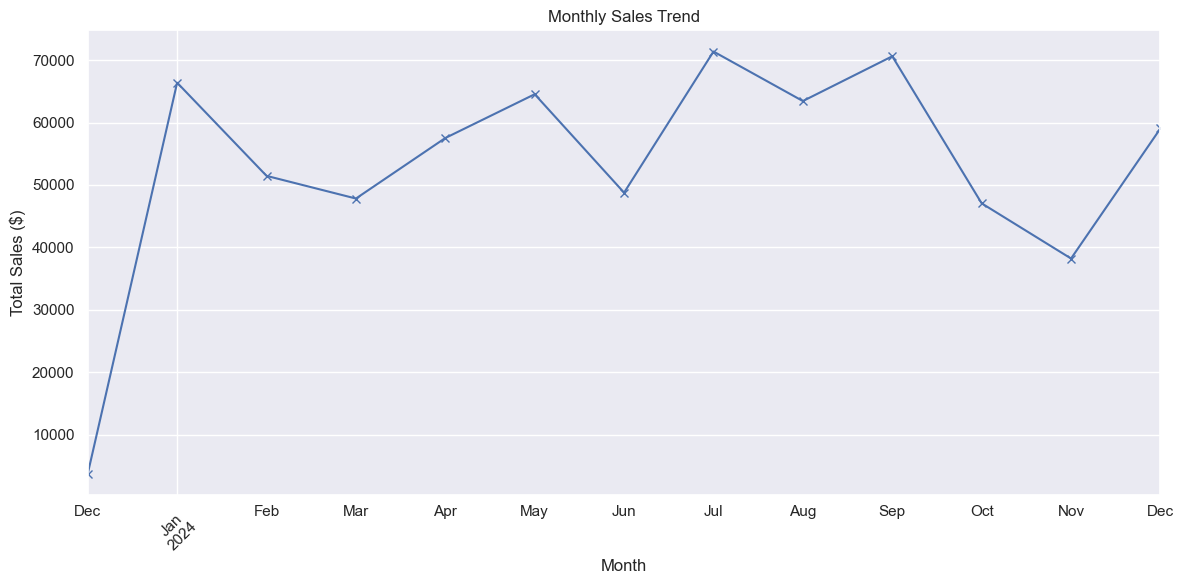

In [52]:
print("Transaction Statistics:")
print("\n")
print("Total number of transactions:")
print(len(transactions))
print(f"Total revenue: ${full_data['TotalValue'].sum():,.2f}")
full_data['TransactionMonth'] = full_data['TransactionDate'].dt.to_period('M')
monthly_sales = full_data.groupby('TransactionMonth')['TotalValue'].sum()
plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='line', marker='x')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [53]:
customer_frequency = transactions['CustomerID'].value_counts()
print("Customer Purchase Frequency:")
print(customer_frequency.describe())

Customer Purchase Frequency:
count    199.000000
mean       5.025126
std        2.198340
min        1.000000
25%        3.000000
50%        5.000000
75%        6.000000
max       11.000000
Name: count, dtype: float64


In [58]:
customer_stats = full_data.groupby('CustomerID').agg({
        'TransactionID': 'count',
        'TotalValue': ['sum', 'mean'],
        'ProductID': 'nunique'
    })
customer_stats.columns = ['Purchase_Count', 'Total_Spent', 'Avg_Order_Value', 'Unique_Products']
customer_stats['Days_Active'] = (customer_purchase_dates['max'] - customer_purchase_dates['min']).dt.days
customer_stats['Purchase_Frequency'] = customer_stats['Purchase_Count'] / customer_stats['Days_Active'].replace(0, 1)
customer_stats['CLV'] = customer_stats['Total_Spent'] / customer_stats['Days_Active'].replace(0, 1) * 365  
print("\nCustomer Metrics Summary:")
customer_stats



Customer Metrics Summary:


,Purchase_Count,Total_Spent,Avg_Order_Value,Unique_Products,Days_Active,Purchase_Frequency,CLV
CustomerID,,,,,,,
C0001,5,3354.52,670.904000,5,288,0.017361,4251.388194
C0002,4,1862.74,465.685000,4,278,0.014388,2445.683813
C0003,4,2725.38,681.345000,4,188,0.021277,5291.296277
C0004,8,5354.88,669.360000,8,299,0.026756,6536.893645
C0005,3,2034.24,678.080000,3,233,0.012876,3186.684979
...,...,...,...,...,...,...,...
C0196,4,4982.88,1245.720000,3,130,0.030769,13990.393846
C0197,3,1928.65,642.883333,3,349,0.008596,2017.069484
C0198,2,931.83,465.915000,2,5,0.400000,68023.590000


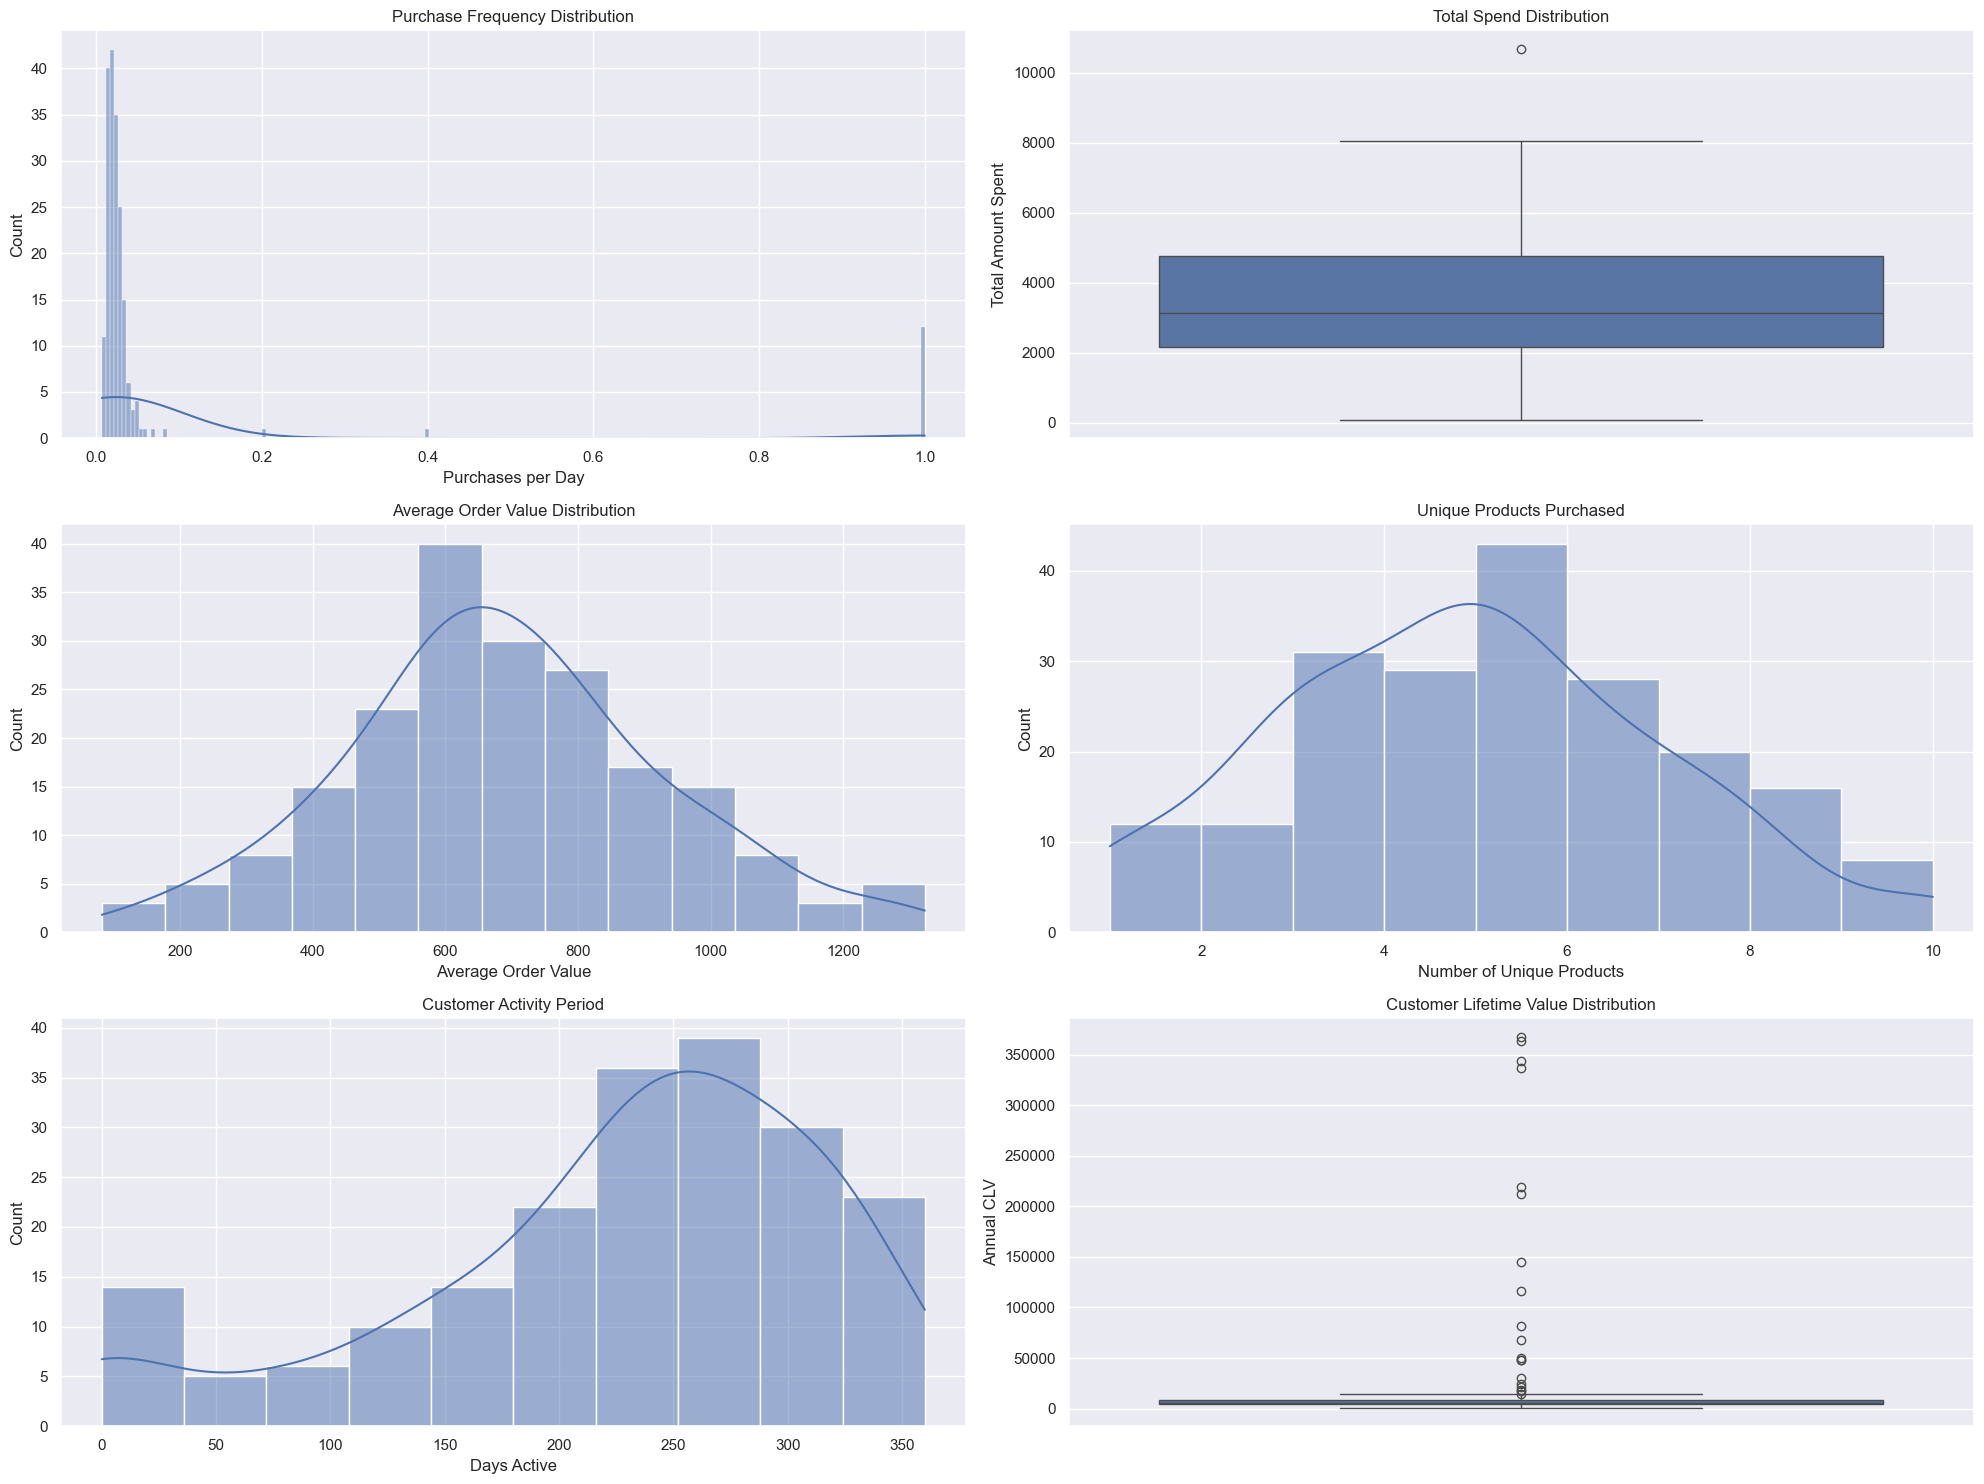

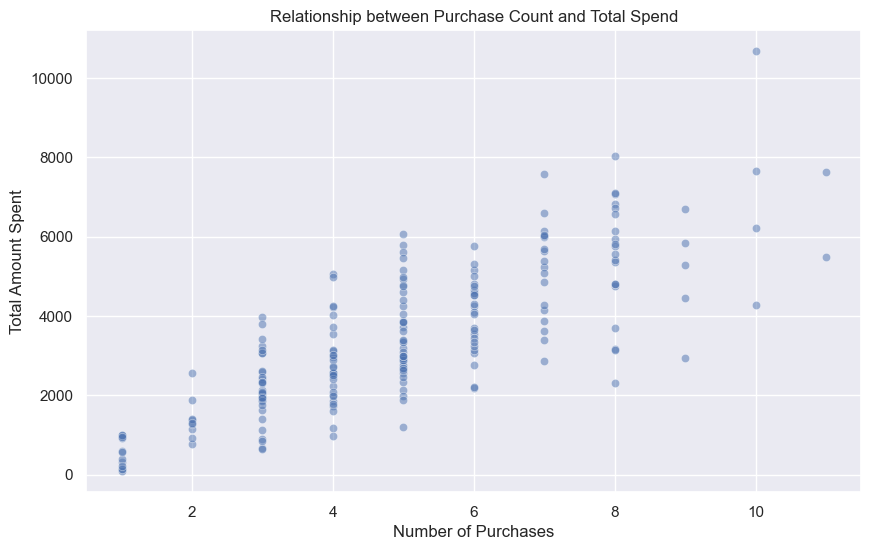

In [59]:
# visualization of customer metrics
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

# purchase frequency distribution
sns.histplot(customer_stats['Purchase_Frequency'], kde=True, ax=axes[0,0])
axes[0,0].set_title('Purchase Frequency Distribution')
axes[0,0].set_xlabel('Purchases per Day')

# total spend
sns.boxplot(y=customer_stats['Total_Spent'], ax=axes[0,1])
axes[0,1].set_title('Total Spend Distribution')
axes[0,1].set_ylabel('Total Amount Spent')


sns.histplot(customer_stats['Avg_Order_Value'], kde=True, ax=axes[1,0])
axes[1,0].set_title('Average Order Value Distribution')
axes[1,0].set_xlabel('Average Order Value')

#unique Products
sns.histplot(customer_stats['Unique_Products'], kde=True, ax=axes[1,1])
axes[1,1].set_title('Unique Products Purchased')
axes[1,1].set_xlabel('Number of Unique Products')

#days Active
sns.histplot(customer_stats['Days_Active'], kde=True, ax=axes[2,0])
axes[2,0].set_title('Customer Activity Period')
axes[2,0].set_xlabel('Days Active')

# customer lifetime value
sns.boxplot(y=customer_stats['CLV'], ax=axes[2,1])
axes[2,1].set_title('Customer Lifetime Value Distribution')
axes[2,1].set_ylabel('Annual CLV')

plt.tight_layout()
plt.show()

#relationships
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_stats, x='Purchase_Count', y='Total_Spent', alpha=0.5)
plt.title('Relationship between Purchase Count and Total Spend')
plt.xlabel('Number of Purchases')
plt.ylabel('Total Amount Spent')
plt.show()

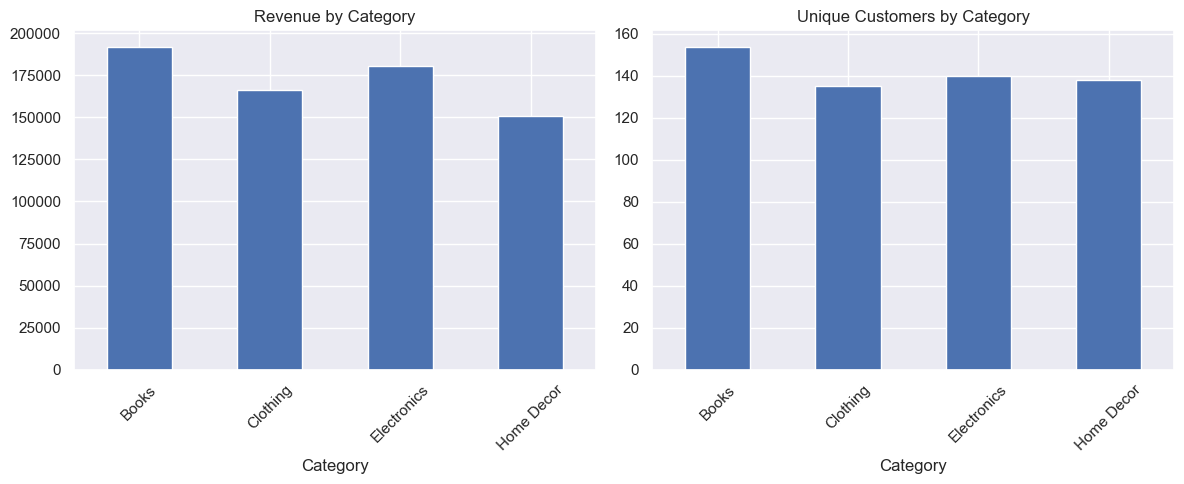

In [62]:
product_stats = full_data.groupby('ProductID').agg({
        'TransactionID': 'count',
        'TotalValue': 'sum',
        'CustomerID': 'nunique'
    })
product_stats.columns = ['Purchase_Count', 'Revenue', 'Unique_Customers']
product_stats['Avg_Revenue_Per_Customer'] = product_stats['Revenue'] / product_stats['Unique_Customers']
category_stats = full_data.groupby('Category').agg({
        'TotalValue': 'sum',
        'TransactionID': 'count',
        'CustomerID': 'nunique'
    })
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
category_stats['TotalValue'].plot(kind='bar')
plt.title('Revenue by Category')
plt.xticks(rotation=45)
plt.subplot(1, 2, 2)
category_stats['CustomerID'].plot(kind='bar')
plt.title('Unique Customers by Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [63]:
#region analysis
regional_metrics = full_data.groupby('Region').agg({
        'TotalValue': ['sum', 'mean'],
        'CustomerID': 'nunique',
        'TransactionID': 'count'
    })
regional_metrics['Orders_Per_Customer'] = (regional_metrics[('TransactionID', 'count')] / regional_metrics[('CustomerID', 'nunique')])
print("\nRegional Performance Metrics:")
print(regional_metrics)
#insights
insights = []
top_customers = full_data.groupby('CustomerID')['TotalValue'].sum().nlargest(10)
insights.append(f"Top 10 customers contribute ${top_customers.sum():,.2f} in revenue")
product_revenue = full_data.groupby('ProductName')['TotalValue'].sum()
top_products = product_revenue.nlargest(5)
insights.append(f"Top 5 products account for {(top_products.sum()/product_revenue.sum()*100):.1f}% of revenue")
region_customers = full_data.groupby('Region')['CustomerID'].nunique()
insights.append(f"Customer distribution: {region_customers.to_dict()}")
monthly_growth = full_data.groupby(full_data['TransactionDate'].dt.to_period('M'))['TotalValue'].sum().pct_change()
avg_monthly_growth = monthly_growth.mean() * 100
insights.append(f"Average monthly growth rate: {avg_monthly_growth:.1f}%")
print("\nKey Business Insights:")
for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}")


Regional Performance Metrics:
              TotalValue             CustomerID TransactionID  \
                     sum        mean    nunique         count   
Region                                                          
Asia           152074.97  697.591606         44           218   
Europe         166254.63  710.489872         50           234   
North America  152313.40  624.235246         46           244   
South America  219352.56  721.554474         59           304   

              Orders_Per_Customer  
                                   
Region                             
Asia                     4.954545  
Europe                   4.680000  
North America            5.304348  
South America            5.152542  

Key Business Insights:
1. Top 10 customers contribute $76,013.31 in revenue
2. Top 5 products account for 19.4% of revenue
3. Customer distribution: {'Asia': 44, 'Europe': 50, 'North America': 46, 'South America': 59}
4. Average monthly growth rate: 140.7%
